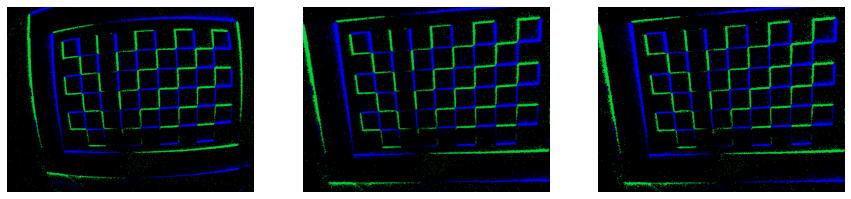

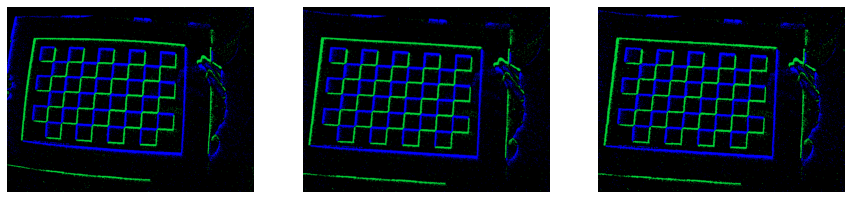

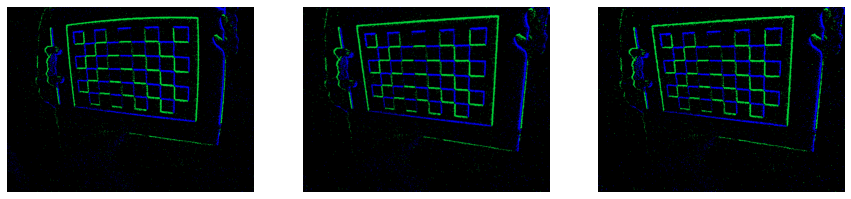

In [1]:

%matplotlib inline

import xml.etree.ElementTree as ET
import re
import numpy as np
import cv2 as cv
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

'''
For camera N: load params from cam<N>.xml and use distorted_<N>.png to create distortion maps
The distortion maps are saved in mapx_cam<N>.csv and mapy_cam<N>.csv
'''

def load_params(filename):

    tree = ET.parse(filename)
    root = tree.getroot()

    w = int(root[0][2].text) # number of columns in camera sensor
    h = int(root[0][3].text) # number of rows in camera sensor

    # Regular expression to get values out of *.xml
    rescinot = re.compile('[-+]?[\d]+\.?[\d]*[Ee](?:[-+]?[\d]+)?|[\d]')

    # Get Camera Matrix 
    cam_m = np.array(re.findall(rescinot, root[0][0][3].text))

    # Get Distortion Coefficients
    d_coeff = np.array(re.findall(rescinot, root[0][1][3].text))

    # Refactoring matrices and coefficients
    cam_m = cam_m.astype(np.float64).reshape((3,3))
    d_coeff = d_coeff.astype(np.float64)
    
    return w, h, cam_m, d_coeff


def plot_all(distorted, undistorted_1, undistorted_2):
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[0].imshow(distorted)
    axs[1].imshow(undistorted_1)  
    axs[2].imshow(undistorted_2)  
    
    
def get_distortion_maps(camera_id):
     
    # Reading parameters from *.xml
    w, h, cam_m, d_coeff = load_params("calibration/cam" + str(camera_id) + ".xml")
        
    # Undistorting stuff ...
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(cam_m, d_coeff, (h,w), 0, (h,w))
    mapx, mapy = cv.initUndistortRectifyMap(cam_m, d_coeff, None, newcameramtx, (w,h), 5)
    
    
    np.savetxt("mapx_cam" + str(camera_id) + ".csv", mapx, delimiter=",")
    np.savetxt("mapy_cam" + str(camera_id) + ".csv", mapy, delimiter=",")
    
    return mapx, mapy
 
def undistort_pt_by_pt(array, mapx, mapy):
    
    x = array.shape[1]
    y = array.shape[0]
        
    undistorted = np.zeros(array.shape, dtype=int)
    
    for i in range(x): #640
        for j in range(y): #480            
            old_x = int(mapx[j, i]) # WARNING: might be [j, i] ...
            old_y = int(mapy[j, i]) # WARNING: might be [j, i] ...
            if ((old_x>=0) and (old_x<x)) and ((old_y>=0) and (old_y<y)):
                undistorted[j, i, :] = distorted[old_y, old_x, :]
    
    return undistorted
                

if __name__ == "__main__":
    
    
    for i in range(3):
        
        # Which camera?
        camera_id = i+1

        # Which image?
        distorted = cv.imread("distorted_" + str(camera_id) + ".png")

        # Get distortion maps
        mapx, mapy = get_distortion_maps(camera_id)

        # Get undistorted image (using cv.remap)
        undistorted = cv.remap(distorted, mapx, mapy, cv.INTER_LINEAR)

        # Get undistorted image (using distortion maps)
        new_undistorted = undistort_pt_by_pt(distorted, mapx, mapy)

        # Plot distorted and undistorted images
        plot_all(distorted, undistorted, new_undistorted)